# "ResNet for Traffic Sign Classification With PyTorch"
> "This is my implementation of an existing blog posts on Traffic Sign classification. The previous work done by Pavel Surmenok was based on Fastai v1, so I have tried to update it to Fastai v2. If you are interested in computer vision in autonomous driving, and you want to learn more about Fastai this will be a great starting point!🚗"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastai, computer vision, traffic sign]
- image: images/traffic.png

# Introduction
In the Intelligent Systems course from my degree, we were asked to write a report about a Neural Network related topic. In class, we were introduced to the [German Traffic Sign Recognition Benchmark dataset](https://benchmark.ini.rub.de/?section=gtsrb&subsection=about), so I decided to explore previous work of the community. This is how I discovered [Pavel Surmenok](https://medium.com/@surmenok) which has a [post](https://medium.com/towards-data-science/resnet-for-traffic-sign-classification-with-pytorch-5883a97bbaa3) dedicated to this subject, using Fastai!<br>
As Pavel's implementation was using the first version of Fastai and I wanted to get more familiar with this library I thought it would be a good idea to try to implement a version of his code using the newest version of Fastai (version 2.5.3 at the time of doing the notebook). So the objectives are the following:


*   Get hands-on experience with Fastai to apply the theory I know of deep learning. I think it is a great tool for rapid testing with impressive results. Start building things!
*   Best case scenario, being able to contribute to updating the work that **Pavel** presented in his blog and help anyone who wants to start with Fastai v2.
*   Try to explain things I didn't know before and I would like to find somewhere. The aim of this is to consolidate the knowledge and also help anyone that had the same questions.



# Imports


In [ ]:
#hide

! pip install -Uqq fastai   # upgrade fastai on colab, by default is v1

In [ ]:
#hide

# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import fastai
fastai.__version__  # check that we have Fastai v2

'2.5.6'

Show the collapsed code to see all the imports we will need

In [ ]:
#collapse

from fastai.imports import *
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.vision.core import PILImage
from PIL import ImageOps

import matplotlib.pyplot as plt
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix, f1_score

import torch

import time
import pandas as pd

We will use the following variable to tell Pytorch to allocate the tensors into the GPU if we have access to one. If not, all the processing will be made on the CPU (NOT recommended, it will be very slow)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Download the datasets

> Warning: Check the download links in case the dataset has been moved. For example, the links provided in Pavel's blog post are no longer working. You can find all the versions released [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html).

In [ ]:
#collapse

# Download and unpack the training set and the test set

! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P data
! unzip data/GTSRB_Final_Training_Images.zip -d data
! unzip data/GTSRB_Final_Test_Images.zip -d data
! unzip data/GTSRB_Final_Test_GT.zip -d data

# Move the test set to data/test

! mkdir data/test
! mv data/GTSRB/Final_Test/Images/*.ppm data/test

# Download class names
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P data

The following are some functions and code used to organize and divide our data into training, validation and test set.


> Tip: It is not directly related to Fastai or Deep Learning, but knowing how to manage your data is VERY important, and Pavel makes it in an understandable and elegant way. If you don't have a lot of confidence working with data this is a section worth looking at. 

Annotations will be named tuples containing the name of the file and its corresponding label. You can find a complete tutorial on `namedtuple()` [here](https://realpython.com/python-namedtuple/), but basically, those are tuple-like immutable data structures with named fields. 


In [ ]:
Annotation = namedtuple('Annotation', ['filename', 'label'])

def read_annotations(filename):
    annotations = []

    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            annotations.append(Annotation(filename, label))
            
    return annotations

`load_training_annotations` will loop over all the files from all the classes and returns the annotations of all the training examples.

In [ ]:
def load_training_annotations(source_path):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename))
    return annotations

> Note: `my_list.extend(iter)` will add each element of an iterable,`iter`, to the list `my_list`. If we would have used append we would get a **list of list** of named tuples instead of a **list** of named tuples. 

We have talked about the filenames, labels etc. but our actual data are images. We will use the `copy_files` function to organize the images in training, validation and all (training+validation) folders. 

In [ ]:
def copy_files(label, filenames, source, destination, move=False):
    # copy to the training or validation folders, for the all folder just rename
    func = os.rename if move else shutil.copyfile 
    
    # make a directory for every label
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    # fill the directories with its corresponding files
    for filename in filenames:
        destination_path = os.path.join(label_path, filename)
        if not os.path.exists(destination_path):
            func(os.path.join(source, format(label, '05d'), filename), destination_path)

Finally, we use all the above mentioned to build our own `split_train_validation_sets` function.

In [ ]:
def split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction=0.2):
    """
    Splits the GTSRB training set into training and validation sets.
    """
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)
        
    if not os.path.exists(all_path):
        os.makedirs(all_path)
    
    # annotations will be a list of Annotations(filename, label)
    annotations = load_training_annotations(source_path)

    # filenames will be a dictionary 
    #     keys: label
    #     values: list of file names
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    # for every label calculate the validation_size and populate the directories
    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        
        # get the validation_size, it must be an integer!
        validation_size = int(len(filenames) // 30 * validation_fraction) * 30
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        
        copy_files(label, filenames, source_path, all_path, move=False)
        copy_files(label, train_filenames, source_path, train_path, move=True)
        copy_files(label, validation_filenames, source_path, validation_path, move=True)

Once we have all these functions all we have to do is call them with the appropriate paths.

In [ ]:
path = 'data'
source_path = os.path.join(path, 'GTSRB/Final_Training/Images')
train_path = os.path.join(path, 'train')
validation_path = os.path.join(path, 'valid')
all_path = os.path.join(path, 'all')
validation_fraction = 0.2
split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction)

test_annotations = read_annotations('data/GT-final_test.csv')

# Exploratory analisys

We have our data prepared so, first things first, let's take a look at it.

In [ ]:
# class_names wil be a dictionary of the class name and its label

classes = pd.read_csv('data/signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]
classes

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


We can try to do histogram equalization to see if it improves our results, but in the end, it does not. If you want to try you can use the `HistogramEqualization_item` class as an `item_tfms` for the Fastai pipeline.

> Note: You can also try to implement histogram equalization in the way Pavel does in his notebook, but I could not see the changes visually, maybe something has changed in how Fastai opens images.

In [ ]:
#collapse

# Histogram equalization

class HistogramEqualization_item(Transform):
  def init(self, prefix=None):
    self.prefix = prefix or ''
  def encodes(self, o):
    if type(o) == PILImage:
      ret = ImageOps.equalize(o)
    else:
      ret = o
    return ret
  def decodes(self, o):
    return o

We could start inspecting the data as it is, but Fastai provides us with some useful functions to visualize our data. To use them we will have to integrate this data into Fastai datastructures. We could create a `DataBunch` or `Datasets` or go directly to `Dataloaders`. We will do the last one, but you can find a lot of information in [tutotials](https://docs.fast.ai/tutorial.pets.html#Getting-to-DataLoaders) and [documentation](https://docs.fast.ai/).

In [ ]:
sz = 96
data = ImageDataLoaders.from_folder(path, item_tfms=[Resize(sz,order=0)], bs=256, 
                                    batch_tfms=[*aug_transforms(do_flip=False,
                                                              max_zoom=1.2,
                                                              max_rotate=10,
                                                              max_lighting=0.8,
                                                              p_lighting=0.8),
                                                Normalize.from_stats(*imagenet_stats)])


The `item_tfms` will be applied to every item in our dataset independently (here is where you have to add the `HistogramEqualization_item` transform if you want to try). Those are performed in the CPU every time an item is accessed. In our case, we only use Resize. <br>
Contrary, the `batch_tfms` will be applied to all the images in the batch at the same time. Those are done in the GPU and are very fast. You can find more information about aug_transforms in the [documentation](https://docs.fast.ai/vision.augment.html#aug_transforms), but basically is a wrap of very useful transforms for image data. As you may note, we randomly resize again the images. The reason is that this is the resizing we want to apply to our images, the one we did previously in `ìtem_tmfs` makes all the images the same size and square, to be able to perform `batch_tfms` in the GPU. <br>
These augmentations are key to having a good performance, and this applies to every deep learning project you will work on.

> Note: We normalize using `imagenet_stats` because our models will be pretrained on this dataset, which is way larger than the one we are working with.

Now we can use `show_batch` method to see some examples from our dataset.

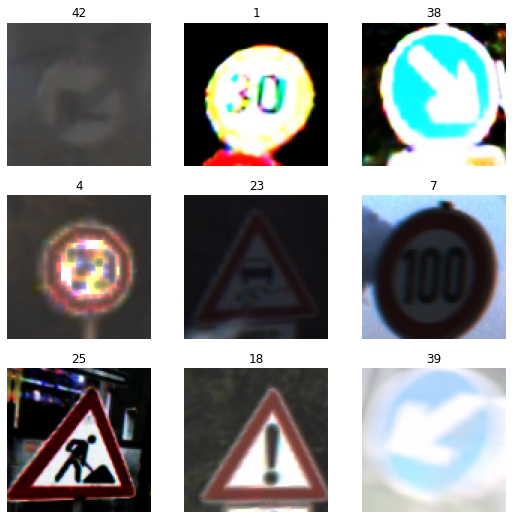

In [ ]:
data.show_batch(nrows=3, ncols=3)

We can also see how the augmentations affect our data by seeing how those affect to a single example.

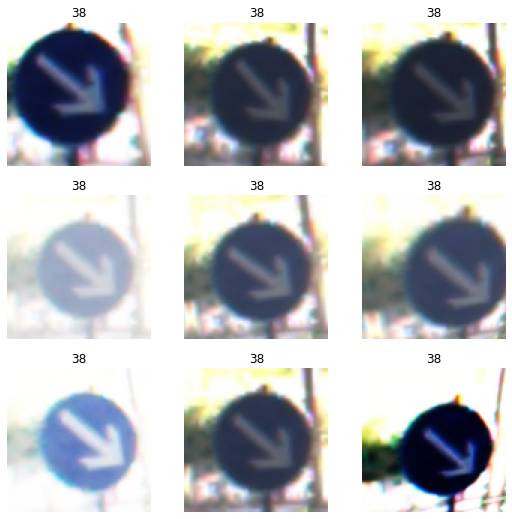

In [ ]:
data.show_batch(nrows=3, ncols=3, unique=True)

We can also check the length of our training and validation set.

In [ ]:
len(data.train_ds), len(data.valid_ds)

(31919, 7290)

> Important: For the sake of the blog post lenght, we finish here our "Exploratory analysis". Nevertheless, explore the data not only includes watching at the data (which is very important), but also the sizes, class distribution etc. A more complete analysis can be found in [Pavel's post](https://medium.com/towards-data-science/resnet-for-traffic-sign-classification-with-pytorch-5883a97bbaa3), and you are encouraged to go further with the help of Fastai.

# Training

## Explore training

In this section, we will try to find the best training hyperparameters to train the model. To do so we will train on the train data and evaluate on the validation data. Then we will use these hyperparameters to train the model on the whole data available (training + validation) and we will test it with the test data.

The metrics we will track will be accuracy and F1-score, because we have seen that the dataset shows class imbalance. The F1-score metric is more robust and informative about the model performance when we are working with this kind of dataset. Concerning the model, we will use a resnet34 pretrained on imagenet. <br>
The data, model, and metrics to track will be wrapped up together in a `learner` object.

In [ ]:
f1_score_mult = FBeta(beta=1, average='weighted')
learn = cnn_learner(data, resnet34, metrics=[accuracy,f1_score_mult])
wd = 5e-4

In [ ]:
#collapse_output

learn.summary() # Display information about the learner obj

Sequential (Input shape: 256 x 3 x 96 x 96)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 48 x 48  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 24 x 24  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

> Important: Our model is frozen up to parameter group #2 (the whole model except the last layer), this means that when running backpropagation the gradients won't be calculated for those layers, hence their weights will remain unchanged.

One of the most important hyperparameters in deep learning is the learning rate. To find a good one we can use `lr_find` method, which takes a batch and runs it through the network with incrementally bigger learning rates recording the loss for each run. The idea is to take the learning rate where the graph of the loss is the steepest. You can try to find it visually or let Fastai give you a suggestion (at least in this case it tend to suggest smaller learning rates).

> Warning: The following code cells aim to illustrate the procedure of how to find a good learning rate. In practice we made more experiments, so you are encouraged to change the values in these cells to see how the training behaves. Don't be afraid to overfit as this will not be the final model. You can set a large number of iterations to see when it starts overfitting so you can train the final model in a more informed way in the next section.

SuggestedLRs(valley=0.0014454397605732083)

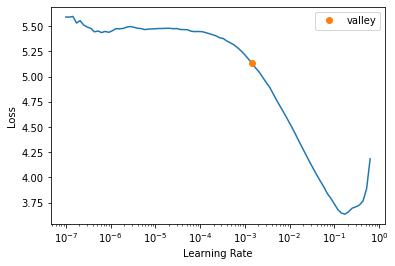

In [ ]:
learn.lr_find()

Train the model with the learning rate selected for one epoch. In this epoch, we will only update the weights of the last layer, as the rest of the model is frozen (with the pretrained weights from imagenet). This will allow our last layer to "catch up" with the other ones and not to start randomly. <br>
The `fit_one_cycle` method uses the 1 cycle policy, which is a learning rate schedule policy consisting in starting from a low learning rate in the firsts epochs, increasing it up to a maximum, to decrease it again for the last epochs. A better explanation can be found in [this post](https://sgugger.github.io/the-1cycle-policy.html) from Sylvain Gugger.

In [ ]:
learn.fit_one_cycle(1, lr_max=0.01, wd=wd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.678658,0.283816,0.912620,0.907962,01:31


Then we unfreeze the model to train it completely. With this, gradients will propagate through the whole network updating all the weights.

In [ ]:
#collapse_output

learn.unfreeze()
learn.summary()

Sequential (Input shape: 256 x 3 x 96 x 96)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 48 x 48  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 24 x 24  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                       

Now we have a different training scenario, so probably our learning rate has changed. So we repeat the process of finding the learning rate and training for some epochs.
We can use `slice` when specifying the learning rate to allows us to use "discriminative layer training", which consists of using different learning rates for different layers. Usually, we use a smaller learning rate for the earlier layers, as they are well trained to detect general features on a lot of data from imagenet, and a bigger one for the last layers, as they have to change more to capture the more specific features from our dataset.

SuggestedLRs(valley=7.585775892948732e-05)

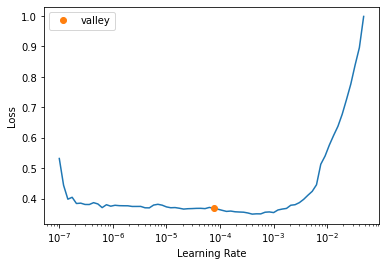

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=0.0001, wd=wd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.246714,0.147343,0.955281,0.952499,01:39
1,0.146424,0.072499,0.978875,0.976936,01:38
2,0.103370,0.058963,0.981207,0.980122,01:38


SuggestedLRs(valley=0.00010964782268274575)

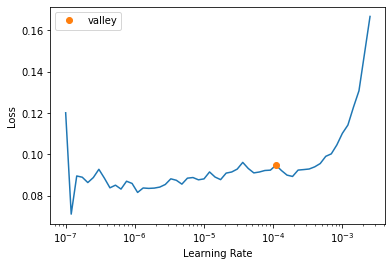

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, lr_max=slice(0.0001, 0.001), wd=wd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.129003,0.121664,0.964060,0.961695,01:38
1,0.154504,0.091829,0.972154,0.972103,01:38
2,0.112813,0.095111,0.976818,0.975057,01:38
3,0.085590,0.068722,0.980796,0.978797,01:38
4,0.078014,0.053779,0.985048,0.983045,01:39
5,0.061613,0.049854,0.985871,0.984394,01:38
6,0.049434,0.050435,0.986420,0.984607,01:39


## Retrain on the whole dataset

Once we have tried different configurations and selected the one we think is best, it is time to train the model with all the data!

In [ ]:
f1_score_mult = FBeta(beta=1, average='weighted')
sz = 96
bs = 256
wd = 5e-4

In [ ]:
data = ImageDataLoaders.from_folder(path, item_tfms=[Resize(sz,order=0)], bs=256, 
                                    batch_tfms=[*aug_transforms(do_flip=False,
                                                              max_zoom=1.2,
                                                              max_rotate=10,
                                                              max_lighting=0.8,
                                                              p_lighting=0.8),
                                                Normalize.from_stats(*imagenet_stats)],
                                    train='all')

learn = cnn_learner(data, resnet34,metrics=[accuracy,f1_score_mult])

In [ ]:
learn.fit_one_cycle(1, lr_max=0.01, wd=wd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.542564,0.107461,0.964746,0.964709,01:46


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(0.001,0.01), wd=wd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.385180,0.500579,0.864060,0.859983,01:58
1,0.210768,0.012989,0.995610,0.995585,01:58
2,0.111806,0.003372,0.998903,0.998901,01:58
3,0.063384,0.000662,0.999863,0.999863,01:58


In [ ]:
learn.fit_one_cycle(6, lr_max=slice(0.0001,0.001), wd=wd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.059273,0.000613,0.999863,0.999863,01:58
1,0.059253,0.001651,0.999451,0.999452,01:58
2,0.058100,0.000631,0.999726,0.999726,01:58
3,0.048571,0.000100,1.000000,1.000000,01:58
4,0.042215,0.000125,1.000000,1.000000,01:58
5,0.038188,0.000095,1.000000,1.000000,01:57


# Test

For the test, we will use "Test time augmentations". This technique is also used by Pavel and shows an increase in the performance of the model. It consists in, instead of just making the prediction of the given test image, making the prediction of the original and other augmented versions of this image using the augmentations used while training. The final prediction will be an average of all of them. This will take more time for each prediction but it will make them more robust. <br>
`test_time_aug` function will test the model with a different number of augmentations and it will return a Pandas Dataframe with the F1-scores and the time it has taken to run the inference of the test set.

In [ ]:
def test_time_aug(learner, test_dataloader, metric, n_augs=[10], beta=0.1):
    res = []
    for aug in n_augs:

      if aug == 0:
        start = time.time()
        log_preds,_ = learner.get_preds(dl=test_dataloader)
        end = time.time()
        infer_time = end-start
      else:
        start = time.time()
        log_preds,_ = learn.tta(dl=test_dataloader, n=aug, beta=beta)
        end = time.time()
        infer_time = end-start

      preds = np.argmax(log_preds,1)
      score = metric(preds, y_true)

      res.append([aug, score, infer_time])

      print(f'N Augmentations: {aug}\tF1-score: {score}\tTime:{infer_time}')

    return pd.DataFrame(res, columns=['n_aug', 'score', 'time'])

As we did before, we need the test data to be in a DataLoader format.

In [ ]:
true_test_labels = {a.filename: a.label for a in test_annotations} #get the annotations in a dictionary format
class_indexes = data.vocab.o2i    #dictionary from class to index
test_img=get_image_files('./data/test') #list of the test image file paths
filenames = [filepath.name for filepath in test_img] #get the names from the file paths
labels = [str(true_test_labels[filename]) for filename in filenames] #list of the labels for each file
y_true = np.array([class_indexes[label] for label in labels]) #array of the index for each label

In [ ]:
test_dataloader=data.test_dl(test_img, bs=256, shuffle=False)

In [ ]:
len(test_dataloader.dataset)

12630

In [ ]:
metric = partial(f1_score, average='weighted')

results = test_time_aug(learn, test_dataloader, metric, n_augs=[0, 3, 5, 10, 15, 20, 30])

N Augmentations: 0	F1-score: 0.994469328801153	Time:19.947819232940674


N Augmentations: 3	F1-score: 0.9943121917876697	Time:81.12456560134888


N Augmentations: 5	F1-score: 0.9950268203228465	Time:119.88853621482849


N Augmentations: 10	F1-score: 0.9959702387438432	Time:218.91360545158386


N Augmentations: 15	F1-score: 0.996130519244009	Time:317.34042143821716


N Augmentations: 20	F1-score: 0.996285695102012	Time:414.57182717323303


N Augmentations: 30	F1-score: 0.9963671397829769	Time:617.6512229442596


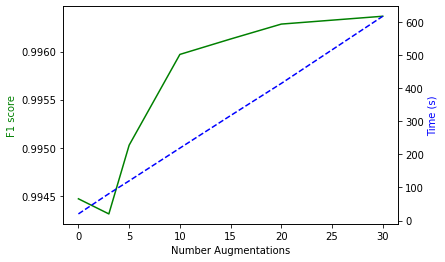

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(results['n_aug'], results['score'], 'g-')
ax2.plot(results['n_aug'], results['time'], 'b--')

ax1.set_xlabel('Number Augmentations')
ax1.set_ylabel('F1 score', color='g')
ax2.set_ylabel('Time (s)', color='b')

plt.show()

So we are getting a F1-score of 0.996367. Not bad at all! Who wants an autonomous ride?? 🥳 😆

# Save the model

In [ ]:
#save the learner and the model, just in case
torch.save(learn.model.state_dict(), 'resnet34_weights.pth')